# Inverse problem for the Poisson equation with unknown forcing field

## Problem setup

We will solve

$$
\frac{d^2u}{dx^2} = q(x), \quad x \in [-1, 1]
$$

with the Dirichlet boundary conditions

$$
u(-1) = 0, \quad u(1) = 0
$$

Here, both $u(x)$ and $q(x)$ are unknown. Furthermore, we have the measurement of $u(x)$ at 100 points.

The reference solution is $u(x) = \sin(\pi x), \quad q(x) = -\pi^2 \sin(\pi x)$.

## Dimensional analysis


**Assumptions on dimensions:**
- Let $[x] = L$, where $L$ represents length.
- Let $[u] = U$, where $U$ represents the dimension of the unknown field $u$. For instance, $u$ could represent displacement, temperature, potential, etc. The exact choice of $U$ depends on the physical context.
- The dimension of $q(x)$ is to be determined.

**Dimensional Analysis:**

1. Consider the left-hand side (LHS): $\frac{d^2 u}{dx^2}$
   Its dimension is:
   
   
   $$
   \left[\frac{d^2 u}{dx^2}\right] = \frac{[u]}{[x]^2} = \frac{U}{L^2}.
   $$

2. For the equation to be dimensionally consistent, the right-hand side (RHS) $q(x)$ must have the same dimension as the LHS:
   $$
   [q(x)] = \frac{U}{L^2}.
   $$

**Summary:**
- If the dimension of $u$ is $U$ and the dimension of $x$ is $L$, then the source term $q(x)$ must have the dimension $U/L^2$.

In other words, the source term $q(x)$ is the field quantity $u$ per unit length squared. The physical meaning depends on the specific problem. For example, if $u$ represents temperature, then $q(x)$ might represent a thermal energy source density. If $u$ represents an electric potential, then $q(x)$ may relate to charge distribution (scaled appropriately by physical constants).



## Implementation

Import the necessary package:


In [6]:
import brainstate as bst
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np

import deepxde.experimental as deepxde


Define the units for the problem:

In [7]:
unit_of_x = u.meter
unit_of_u = u.newton
unit_of_q = u.newton / unit_of_x ** 2


Define the problem.

In [8]:
def pde(x, y):
    du_xx = net.hessian(x, y='u')['u']['x']['x']
    return -du_xx + y['q']


geom = deepxde.geometry.Interval(-1, 1).to_dict_point(x=unit_of_x)


Define the Dirichlet boundary conditions.

In [9]:
def sol(x):
    # solution is u(x) = sin(pi*x), q(x) = -pi^2 * sin(pi*x)
    # return {'u': u.math.sin(u.math.pi * x['x']), }
    return {
        'u': u.math.sin(u.math.pi * x['x'] / unit_of_x) * unit_of_u,
        'q': -u.math.pi ** 2 * u.math.sin(u.math.pi * x['x'] / unit_of_x) * unit_of_q
    }


bc = deepxde.icbc.DirichletBC(sol)


Define the observation points and the training data generator.

In [10]:
def gen_traindata(num):
    # generate num equally-spaced points from -1 to 1
    xvals = np.linspace(-1, 1, num)
    uvals = np.sin(np.pi * xvals)
    return {'x': xvals * unit_of_x}, {'u': uvals * unit_of_u}


ob_x, ob_u = gen_traindata(100)
observe_u = deepxde.icbc.PointSetBC(ob_x, ob_u)

Define the neural network model, adding the unit information to the input and output:

In [11]:
net = deepxde.nn.Model(
    deepxde.nn.DictToArray(x=unit_of_x),
    deepxde.nn.PFNN([1, [20, 20], [20, 20], [20, 20], 2], "tanh", bst.init.KaimingUniform()),
    deepxde.nn.ArrayToDict(u=unit_of_u, q=unit_of_q),
)

The final problem:

In [12]:
problem = deepxde.problem.PDE(
    geom,
    pde,
    [bc, observe_u],
    net,
    num_domain=200,
    num_boundary=2,
    anchors=ob_x,
    num_test=1000,
    loss_weights=[1, 100, 1000],
)

Train the model:

Compiling trainer...
'compile' took 0.049581 s

Training trainer...

Step      Train loss                                     Test loss                                      Test metric 
0         [57.104668 * pascal2,                          [58.55549 * pascal2,                           []          
           {'ibc0': {'q': 71.43462 * pascal,              {'ibc0': {'q': 71.43462 * pascal,                         
                     'u': 21.93853 * newton}},                      'u': 21.93853 * newton}},                       
           {'ibc1': {'u': 1383.2239 * newton}}]           {'ibc1': {'u': 1383.2239 * newton}}]                      
1000      [9.099975 * pascal2,                           [9.277513 * pascal2,                           []          
           {'ibc0': {'q': 0.02584232 * pascal,            {'ibc0': {'q': 0.02584232 * pascal,                       
                     'u': 39.094223 * newton}},                     'u': 39.094223 * newton}},                  

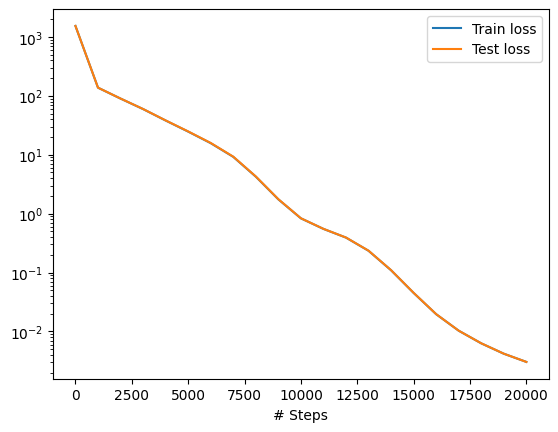

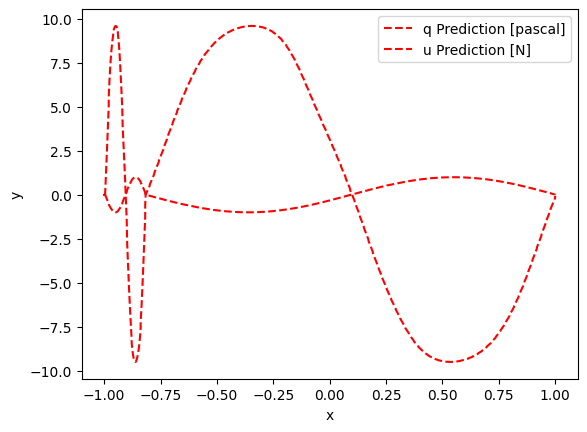

In [13]:
model = deepxde.Trainer(problem)
model.compile(bst.optim.Adam(0.0001)).train(iterations=20000)
model.saveplot(issave=True, isplot=True)


Visualize the results:

l2 relative error for u: 0.0022317795
l2 relative error for q: 0.02959022


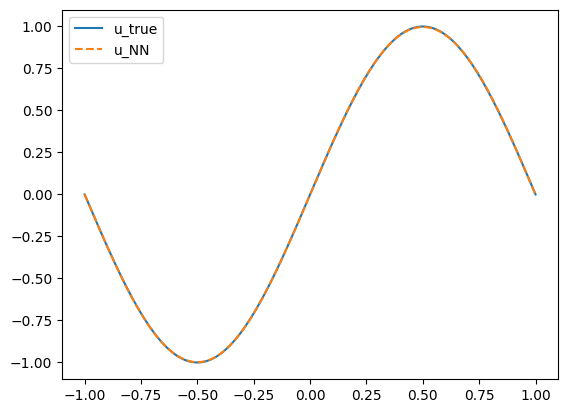

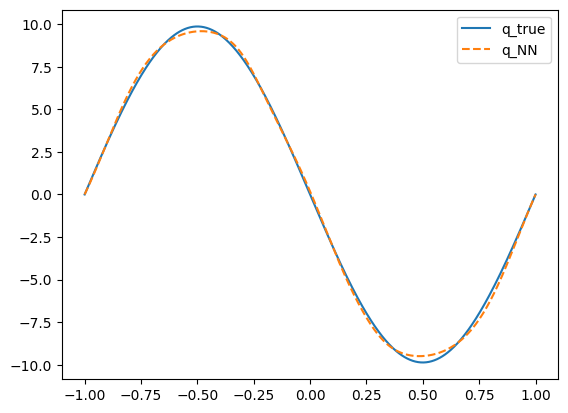

In [14]:

# view results
x = geom.uniform_points(500)
yhat = model.predict(x)
uhat = yhat['u'] / unit_of_u
qhat = yhat['q'] / unit_of_q
x = x['x'] / unit_of_x

utrue = np.sin(np.pi * x)
print("l2 relative error for u: " + str(deepxde.metrics.l2_relative_error(utrue, uhat)))
plt.figure()
plt.plot(x, utrue, "-", label="u_true")
plt.plot(x, uhat, "--", label="u_NN")
plt.legend()

qtrue = -np.pi ** 2 * np.sin(np.pi * x)
print("l2 relative error for q: " + str(deepxde.metrics.l2_relative_error(qtrue, qhat)))
plt.figure()
plt.plot(x, qtrue, "-", label="q_true")
plt.plot(x, qhat, "--", label="q_NN")
plt.legend()

plt.show()

Complete code please see the code in [elliptic_inverse_field.py](https://github.com/chaobrain/pinnx/blob/main/docs/unit-examples-forward/elliptic_inverse_field.py).